In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen, phate
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


Ligand **-***sender|receiver***->** Receptor **-->** Pathway **-->** Target 

* L-R interactions from NichetNet (or anything else really)
* Target gene list from Nichenet too. 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

We will have to be carefull with the targets added, as in the previous nichenetKG they were the vast majority of nodes.


# Get data from databases

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

NicheNet

In [4]:
%%R -o dNNlr,dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))
# dNNgrt = readRDS(url("https://zenodo.org/record/3260758/files/tf_target_matrix.rds"))
# dNNlt = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))

In [5]:
print("Ligand-Receptor\n",dNNlr.describe())
print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304
TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691


from         to              source           database
1        CXCL1      CXCR2      kegg_cytokines               kegg
2        CXCL2      CXCR2      kegg_cytokines               kegg
3        CXCL3      CXCR2      kegg_cytokines               kegg
4        CXCL5      CXCR2      kegg_cytokines               kegg
5         PPBP      CXCR2      kegg_cytokines               kegg
...        ...        ...                 ...                ...
12647    CXCL6       PIGR           ppi_lr_go  ppi_prediction_go
12648     RLN1      GPR25           ppi_lr_go  ppi_prediction_go
12649     RLN1      RAMP3           ppi_lr_go  ppi_prediction_go
12650   PIK3CB  TNFRSF10A      ppi_bidir_r_go  ppi_prediction_go
12651  PCDHGB1     PCDHA6  ppi_bidir_bidir_go  ppi_prediction_go

[12651 rows x 4 columns]

On the L-R side, NicheNet seems to have a higher number of interactions
modelled in. We can just use them *as is*.

The tf_target and ligand_target matrix objects don't look to be as useful since the targets they have are actually, if anything, somewaht longer than the targets in the gene regulation database (uncomment .md below to see)
Manual exploration of the tf_target database revealed that all genes with bio meaning I could think of are present in this list.
Afterall,we have 25k genes in here. This is thus, not useful at all.

<!-- Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304

TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691

TF-Target 2
 (25345, 4486) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
Ligand-Target
 (25345, 688) [[0.00035343 0.00040413 0.00037299 ... 0.00028765 0.00036615 0.00032276]
 [0.00016509 0.00015092 0.00015836 ... 0.00014044 0.0001839  0.00017542]
 [0.00057872 0.00045963 0.00038959 ... 0.00053559 0.00051685 0.00040327]
 ...
 [0.00043514 0.00052277 0.00040791 ... 0.00043696 0.00092245 0.00045744]
 [0.00041811 0.00049604 0.00045687 ... 0.00036184 0.00059071 0.00040423]
 [0.00050178 0.00055816 0.00048933 ... 0.00053238 0.00099519 0.00057892]] -->
 

CellChat

In [6]:
dCClr = pd.read_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz",header=None)
dCClr

0              1       2      3
0     TGFB1  LRinteraction  TGFBR1   TGFb
1     TGFB1  LRinteraction  TGFBR2   TGFb
2     TGFB2  LRinteraction  TGFBR1   TGFb
3     TGFB2  LRinteraction  TGFBR2   TGFb
4     TGFB3  LRinteraction  TGFBR1   TGFb
...     ...            ...     ...    ...
1976  VCAM1  LRinteraction   ITGA4   VCAM
1977  VCAM1  LRinteraction   ITGB1   VCAM
1978  VCAM1  LRinteraction   ITGA9   VCAM
1979  VCAM1  LRinteraction   ITGB7   VCAM
1980   VSIR  LRinteraction  IGSF11  VISTA

[1981 rows x 4 columns]

Merge NicheNet and CellChat LR databases

In [7]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dCClr = pd.DataFrame({
            "head":dCClr[0],
            "relation":np.repeat("LR", dCClr.shape[0]),
            "tail":dCClr[2]
        })
dLR = pd.concat([dNNlr, dCClr]).drop_duplicates().reset_index(drop=True)
del dNNlr,dCClr
dLR

head relation    tail
0      CXCL1       LR   CXCR2
1      CXCL2       LR   CXCR2
2      CXCL3       LR   CXCR2
3      CXCL5       LR   CXCR2
4       PPBP       LR   CXCR2
...      ...      ...     ...
12927   THY1       LR   ITGB2
12928   THY1       LR   ITGAX
12929   THY1       LR   ITGAV
12930   THY1       LR   ITGB3
12931   VSIR       LR  IGSF11

[12932 rows x 3 columns]

Reactome

In [16]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_Pathway.txt", sep="\t", header=None)
# dREACTpe = dREACTpe.loc[dREACTpe[7]=="Homo sapiens"][[0,1,2,3,5]].drop_duplicates() #Rmv duplicates cuz Diff sources
dREACTpe = dREACTpe.loc[dREACTpe[0].str.startswith("ENSG") | dREACTpe[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
dREACTpe

1                                                 2  \
490283   R-HSA-162865             DPM1 [endoplasmic reticulum membrane]   
490284  R-HSA-4717383  DPM1 G111Lfs*45 [endoplasmic reticulum membrane]   
490285  R-HSA-4717361   DPM1 Q210Rfs*4 [endoplasmic reticulum membrane]   
490286  R-HSA-4717370        DPM1 R92G [endoplasmic reticulum membrane]   
490287   R-HSA-162865             DPM1 [endoplasmic reticulum membrane]   
...               ...                                               ...   
707883   R-GGA-418127                                 ACD [nucleoplasm]   
707884   R-GGA-372572           SLC25A13 [mitochondrial inner membrane]   
707885   R-GGA-372572           SLC25A13 [mitochondrial inner membrane]   
707886   R-GGA-433559                                   SPHK1 [cytosol]   
719298   R-GGA-417101                            TERC RNA [nucleoplasm]   

                    3                                              5  
490283   R-HSA-162699        Synthesis of dolichyl-phosphate mannose  
490284  R-HSA-4717374                 Defective DPM1 causes DPM1-CDG  
490285  R-HSA-4717374                 Defective DPM1 causes DPM1-CDG  
490286  R-HSA-4717374                 Defective DPM1 causes DPM1-CDG  
490287  R-HSA-4719360                 Defective DPM3 causes DPM3-CDG  
...               ...                                            ...  
707883   R-GGA-418124                           Telomere maintenance  
707884   R-GGA-352875                                Gluconeogenesis  
707885   R-GGA-372568                          Amino acid metabolism  
707886   R-GGA-433584                        Sphingolipid metabolism  
719298   R-GGA-417076  Assembly of telomerase and telomere extension  

[103378 rows x 4 columns]

Now, grab the receptors by name in column 2 of dRpe and targets too, to build Receptor->pathway and pathway->targets triples.

* To grab genes/protein, we have to match the NN name with a regex that looks for string start, full match, space, and [ bracket.

In [17]:
dREACTnodes = dREACTpe.loc[dREACTpe[2].str.match("^[A-Z0-9]+\S*[A-Z0-9]+(\(\S+\))? \[")][[2,3,5]]#Some entries belong to proteins with no gene entry (like CLU), so we have to use ().Using UPPER\S*UPPER for proteins like Thy1[named GPI-THY] 
dREACTnodes[2] = dREACTnodes[2].str.extract("^([A-Z0-9]+\S*[A-Z0-9]+)")[0]
dREACTnodes = dREACTnodes.drop_duplicates()
dREACTnodes

2              3                                        5
490283      DPM1   R-HSA-162699  Synthesis of dolichyl-phosphate mannose
490287      DPM1  R-HSA-4719360           Defective DPM3 causes DPM3-CDG
490288      DPM1  R-HSA-4719377           Defective DPM2 causes DPM2-CDG
490295       FGR  R-HSA-2029481                          FCGR activation
490296       FGR   R-HSA-432142            Platelet sensitization by LDL
...          ...            ...                                      ...
707882     ACER3   R-GGA-433584                  Sphingolipid metabolism
707883       ACD   R-GGA-418124                     Telomere maintenance
707884  SLC25A13   R-GGA-352875                          Gluconeogenesis
707885  SLC25A13   R-GGA-372568                    Amino acid metabolism
707886     SPHK1   R-GGA-433584                  Sphingolipid metabolism

[71289 rows x 3 columns]

In [18]:
del dREACTpe

In [19]:
dR2Path = dREACTnodes.loc[dREACTnodes[2].isin(dLR["tail"])]
dR2Path


2              3  \
490355    CFTR   R-HSA-382556   
490357    CFTR  R-HSA-5627083   
490369    CFTR  R-HSA-5689880   
490373    CFTR  R-HSA-9013406   
490446    CD99   R-HSA-198933   
...        ...            ...   
697272  ITGA2B  R-GGA-5674135   
707338     VTN  R-GGA-2132267   
707339     VTN  R-GGA-2132281   
707825   C5AR1  R-GGA-2173345   
707886   SPHK1   R-GGA-433584   

                                                        5  
490355             ABC-family proteins mediated transport  
490357              RHO GTPases regulate CFTR trafficking  
490369                   Ub-specific processing proteases  
490373                                  RHOQ GTPase cycle  
490446  Immunoregulatory interactions between a Lympho...  
...                                                   ...  
697272                          MAP2K and MAPK activation  
707338         Formation of membrane attack complex (MAC)  
707339                  Regulation of complement cascades  
707825     Anaphylatoxins initiate inflammatory responses  
707886                            Sphingolipid metabolism  

[3418 rows x 3 columns]

In [20]:
dPath2Gene = dREACTnodes.loc[dREACTnodes[2].isin(dNNgr["to"]) & ~dREACTnodes[2].isin(dLR["head"]) & ~dREACTnodes[2].isin(dLR["tail"]) & ~dREACTnodes[2].isin(dNNgr["from"])]
print(dPath2Gene[2].unique().shape)
dPath2Gene

(6679,)


2              3                                        5
490283      DPM1   R-HSA-162699  Synthesis of dolichyl-phosphate mannose
490287      DPM1  R-HSA-4719360           Defective DPM3 causes DPM3-CDG
490288      DPM1  R-HSA-4719377           Defective DPM2 causes DPM2-CDG
490295       FGR  R-HSA-2029481                          FCGR activation
490296       FGR   R-HSA-432142            Platelet sensitization by LDL
...          ...            ...                                      ...
707879   SLC25A2   R-GGA-187630                      Arginine metabolism
707882     ACER3   R-GGA-433584                  Sphingolipid metabolism
707883       ACD   R-GGA-418124                     Telomere maintenance
707884  SLC25A13   R-GGA-352875                          Gluconeogenesis
707885  SLC25A13   R-GGA-372568                    Amino acid metabolism

[28647 rows x 3 columns]

Note that some pathways are connected only to Receptors or to other gene nodes.

In [21]:
del dREACTnodes

# Build triples dataframe

In [22]:
dLR
dR2Path = pd.DataFrame({
            "head":dR2Path[2],
            "relation":np.repeat("R2Path", dR2Path.shape[0]),
            "tail":dR2Path[3]
        })
dPath2Gene = pd.DataFrame({
            "head":dPath2Gene[3],
            "relation":np.repeat("Path2Gene", dPath2Gene.shape[0]),
            "tail":dPath2Gene[2]
        })

dKGnn = pd.concat([dLR, dR2Path, dPath2Gene]).drop_duplicates().reset_index(drop=True)
del dLR,dR2Path,dPath2Gene
dKGnn

head   relation      tail
0             CXCL1         LR     CXCR2
1             CXCL2         LR     CXCR2
2             CXCL3         LR     CXCR2
3             CXCL5         LR     CXCR2
4              PPBP         LR     CXCR2
...             ...        ...       ...
44992  R-GGA-187630  Path2Gene   SLC25A2
44993  R-GGA-433584  Path2Gene     ACER3
44994  R-GGA-418124  Path2Gene       ACD
44995  R-GGA-352875  Path2Gene  SLC25A13
44996  R-GGA-372568  Path2Gene  SLC25A13

[44997 rows x 3 columns]

In [23]:
dKGnn.to_csv(f"{data_dir}/dKGnn2.csv.tar.gz", index=False, header=False)

In [24]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn2.csv.tar.gz", header=None)
dKGnn

0          1         2
0             CXCL1         LR     CXCR2
1             CXCL2         LR     CXCR2
2             CXCL3         LR     CXCR2
3             CXCL5         LR     CXCR2
4              PPBP         LR     CXCR2
...             ...        ...       ...
44992  R-GGA-187630  Path2Gene   SLC25A2
44993  R-GGA-433584  Path2Gene     ACER3
44994  R-GGA-418124  Path2Gene       ACD
44995  R-GGA-352875  Path2Gene  SLC25A13
44996  R-GGA-372568  Path2Gene  SLC25A13

[44997 rows x 3 columns]

# NetworkX KG

In [25]:
G = networkx.from_pandas_edgelist(dKGnn,source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_17693/1504231106.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 10980 nodes and 44923 edges, with a density of 0.0007453042909704585
We have this many isolates:  0
The graph is connected: False

We have 101 connected subgraphs
Component 1: Graph with 10418 nodes and 44045 edges, with a density of 0.0008117075634650914
Component 2: Graph with 4 nodes and 3 edges, with a density of 0.5
Component 3: Graph with 1 nodes and 1 edges, with a density of 0
Component 4: Graph with 4 nodes and 4 edges, with a density of 0.6666666666666666
Component 5: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 8: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 9: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 10: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 11: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 12: Graph with 23 nodes and 35 edges, 

/tmp/ipykernel_17693/1504231106.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


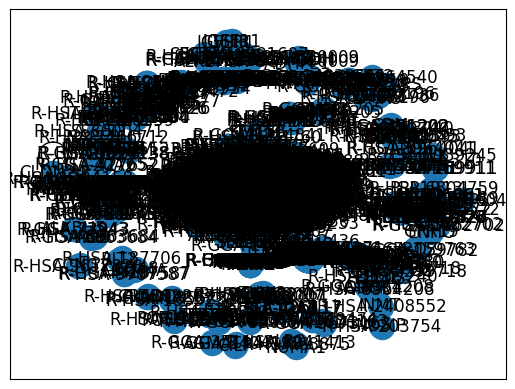

In [26]:
networkx.draw_networkx(G)

In [17]:
# networkx.draw_networkx(Gcomponents[0], node_size=12, font_size=6)#Biggest subcomponent

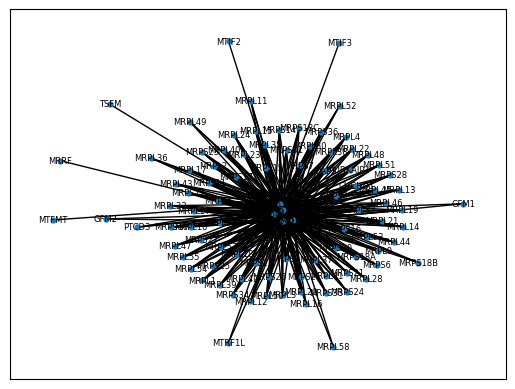

In [27]:
networkx.draw_networkx(Gcomponents[17], node_size=12, font_size=6)#Second biggest subcomponent are Zinc Finger Nucleases!

## Degree analysis

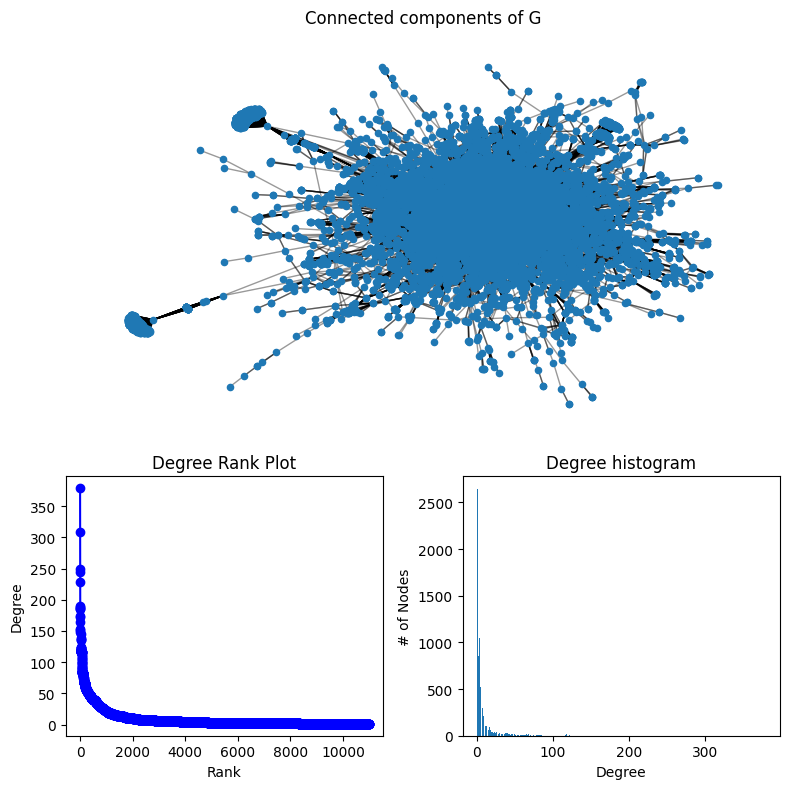

In [28]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# KG Embedding

In [29]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [30]:
tf = TriplesFactory.from_labeled_triples(
        dKGnn.to_numpy(dtype="str"),create_inverse_triples=False)
tf

TriplesFactory(num_entities=10980, num_relations=3, create_inverse_triples=False, num_triples=44997)

In [31]:
import json
with open(f"{data_dir}/dKGnn2_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

In [32]:
modelKGE = "KGnn2_50_unstratified_stopped_transe"

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [26228, 4500, 4500]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/fc489/.data/pykeen/checkpoints/best-model-weights-1d314c13-b093-43e6-b779-39178e9949ad.pt


Training epochs on cuda:0:   0%|          | 0/18 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.
INFO:pykeen.evaluation.evaluator:Evaluation took 1.36s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.037333333333333336. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-1d314c13-b093-43e6-b779-39178e9949ad.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/141 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/4.50k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.40s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=10980, num_relations=3, create_inverse_triples=False, num_triples=35997) to file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGnn2_50_unstratified_stopped_transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///gpfs/ysm/home/fc489/yaleCollab/KGEs/KGnn2_50_unstratified_stopped_transe


TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(10980, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(3, 50)
    )
  )
  (weight_regularizers): ModuleList()
)
CPU times: user 1min 5s, sys: 51.9 s, total: 1min 57s
Wall time: 23.6 s


<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

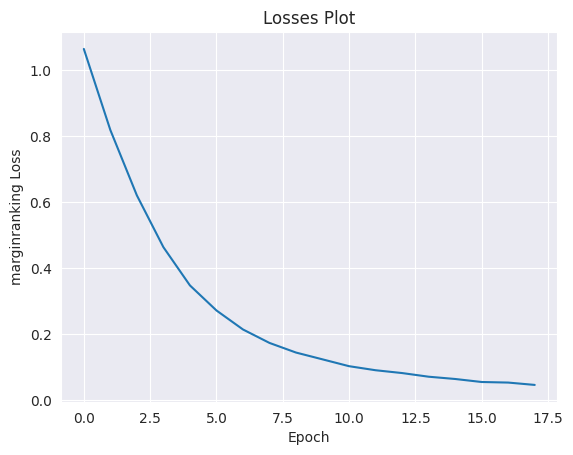

In [34]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=18,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

Increased epochs since diminishing returns start occuring after 20 epochs now (not just below 10)

In [35]:
try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)


#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGnn2_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnn_50

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(10980, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(3, 50)
    )
  )
  (weight_regularizers): ModuleList()
)


0         1         2         3         4         5         6   \
A1CF    -0.091180  0.243288 -0.011943  0.095926  0.177323 -0.165918 -0.073481   
A2M      0.062832  0.196581  0.268760  0.190127 -0.259423 -0.109196  0.069691   
A4GNT    0.134024 -0.015400  0.199409 -0.192547 -0.186682 -0.136548 -0.016398   
AACS    -0.054235 -0.174243  0.161587  0.129849 -0.044168  0.069234 -0.220614   
AADAT   -0.168774  0.103414  0.236731  0.102885  0.107261 -0.026053 -0.023166   
...           ...       ...       ...       ...       ...       ...       ...   
ZSCAN32 -0.066646 -0.046925  0.195356  0.189570  0.182348  0.030408 -0.259591   
ZSWIM8  -0.028611  0.112698 -0.157677  0.080903 -0.065544  0.118098  0.166654   
ZW10    -0.112816 -0.174202  0.015811  0.008290 -0.059898  0.182645 -0.038256   
ZWILCH   0.202985  0.191538 -0.084201 -0.088150 -0.052062  0.272743  0.022529   
ZWINT    0.110148  0.237756 -0.144104 -0.085411  0.129321  0.222715  0.180740   

               7         8         9   ...        40        41        42  \
A1CF     0.168595  0.254401 -0.144717  ... -0.121031 -0.118713  0.235344   
A2M      0.081877 -0.110947  0.008401  ...  0.074373 -0.162736 -0.079121   
A4GNT    0.139040  0.159719  0.356804  ...  0.149425  0.116844  0.134527   
AACS    -0.083207  0.028719 -0.065973  ...  0.084910 -0.133076  0.124274   
AADAT   -0.088772  0.070179  0.311356  ... -0.143309  0.139305  0.213547   
...           ...       ...       ...  ...       ...       ...       ...   
ZSCAN32 -0.027675  0.136061  0.124374  ... -0.058118  0.181539 -0.161893   
ZSWIM8  -0.187142  0.115373  0.221776  ...  0.237138 -0.062988  0.098817   
ZW10    -0.208860  0.068852  0.325017  ... -0.375013 -0.045188 -0.083680   
ZWILCH  -0.001551 -0.090427  0.231667  ... -0.206347 -0.071462  0.062763   
ZWINT    0.184723  0.032267  0.196187  ... -0.125159 -0.017426  0.072546   

               43        44        45        46        47        48        49  
A1CF     0.056422 -0.047393 -0.210884 -0.145817  0.039287 -0.068845 -0.184054  
A2M      0.062362 -0.260063  0.110796  0.143552  0.230752  0.165774  0.191975  
A4GNT    0.138486  0.231214  0.201416 -0.003282  0.004645 -0.122451 -0.085672  
AACS    -0.115348  0.037736 -0.111404 -0.168731 -0.205976 -0.004961 -0.142885  
AADAT    0.043986 -0.141963 -0.162422 -0.160464 -0.141567 -0.029173 -0.201521  
...           ...       ...       ...       ...       ...       ...       ...  
ZSCAN32  0.082484  0.025907  0.035925 -0.027335  0.221116  0.052769 -0.084060  
ZSWIM8   0.008609  0.023608 -0.272479 -0.201570 -0.149621  0.187135  0.179307  
ZW10     0.116554  0.246966 -0.222519 -0.003684 -0.017551 -0.008482  0.111994  
ZWILCH   0.125065  0.192876 -0.083263  0.012744  0.101088 -0.163604  0.227617  
ZWINT    0.192034 -0.082368  0.041726  0.019920 -0.077932 -0.160973 -0.043654  

[10980 rows x 50 columns]

## PCA on KGE

In [36]:
from sklearn.decomposition import PCA

dKGEnn_pca = PCA(n_components=2).fit_transform(dKGEnn_50)
dKGEnn_pca = pd.DataFrame(dKGEnn_pca, index=entityIDS.values())

In [33]:
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="LR",0]) #ligands
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="LR",2])#receptors
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="R2Path",0])#sanity check for receptors
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="R2Path",2])#Pathways with a receptor
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",0])#Pathways with a non-receptor node
dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",2])#non-LR node

array([ True, False,  True, ...,  True,  True,  True])

<AxesSubplot: title={'center': 'non-LR node'}, xlabel='PC-1', ylabel='PC-2'>

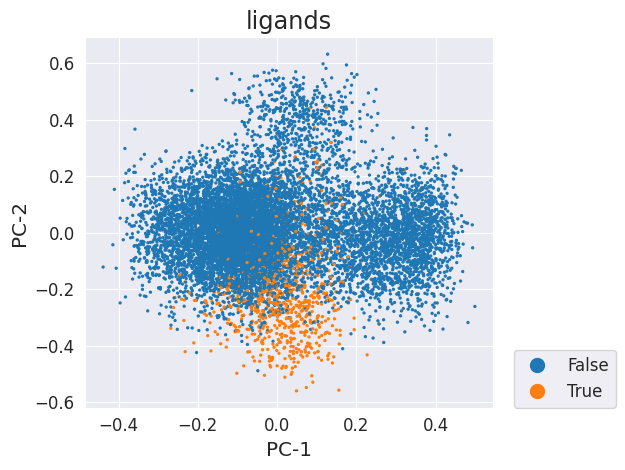

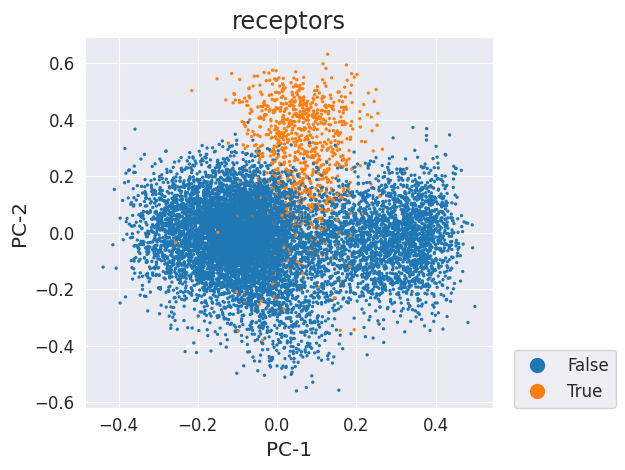

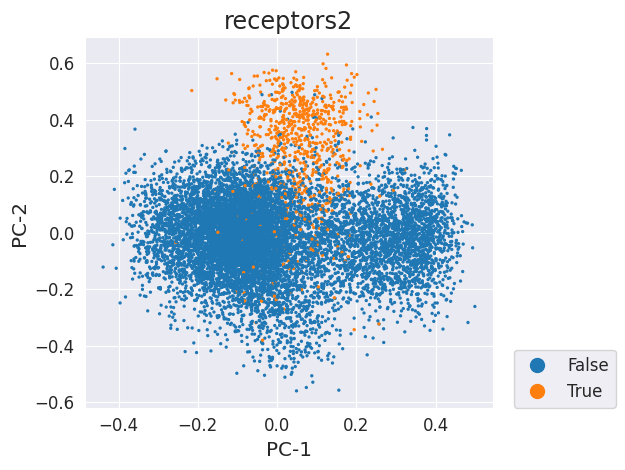

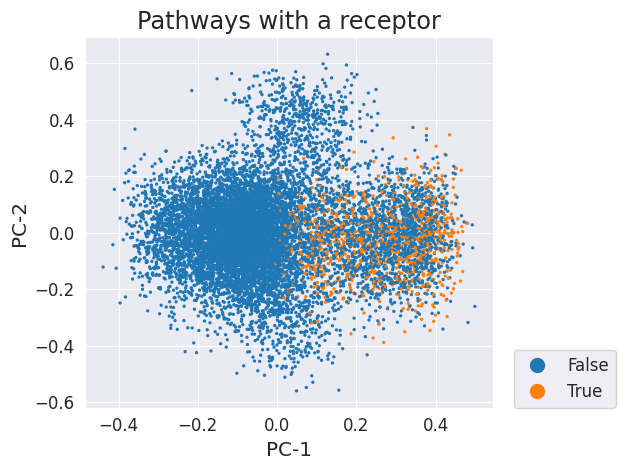

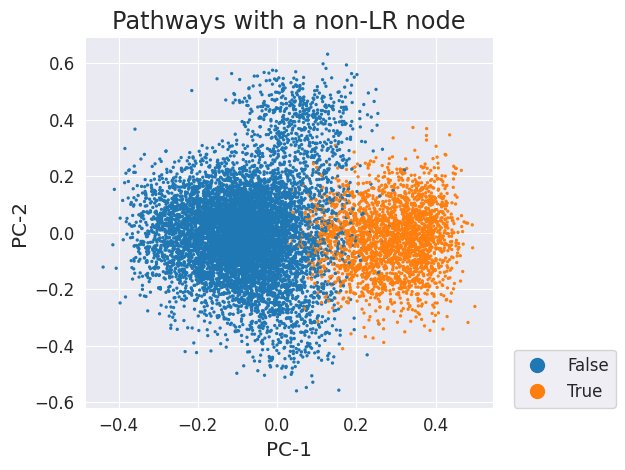

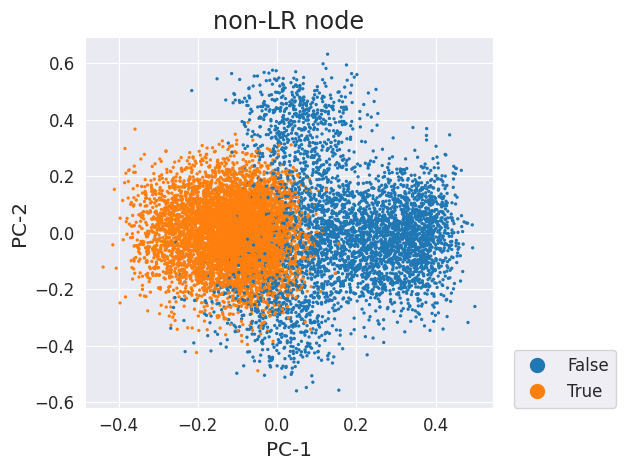

In [37]:
scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="LR",0]), 
    title="ligands", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="LR",2]), 
    title="receptors", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="R2Path",0]), 
    title="receptors2", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="R2Path",2]), 
    title="Pathways with a receptor", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",0]), 
    title="Pathways with a non-LR node", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",2]), 
    title="non-LR node", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

## PHATE on KGE

In [38]:
data_phate = phate.PHATE().fit_transform(dKGEnn_50)
data_phate = pd.DataFrame(data_phate, index=entityIDS.values())

Calculating PHATE...
  Running PHATE on 10980 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.57 seconds.
    Calculating affinities...
    Calculated affinities in 1.55 seconds.
  Calculated graph and diffusion operator in 8.14 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.48 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.80 seconds.
  Calculated landmark operator in 7.62 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 1.09 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.38 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.46 seconds.
Calculated PHATE in 21.71 seconds.


<AxesSubplot: title={'center': 'non-LR node'}, xlabel='PHATE-1', ylabel='PHATE-2'>

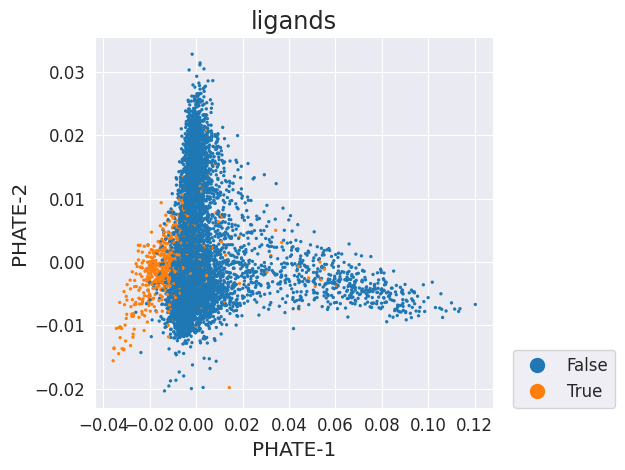

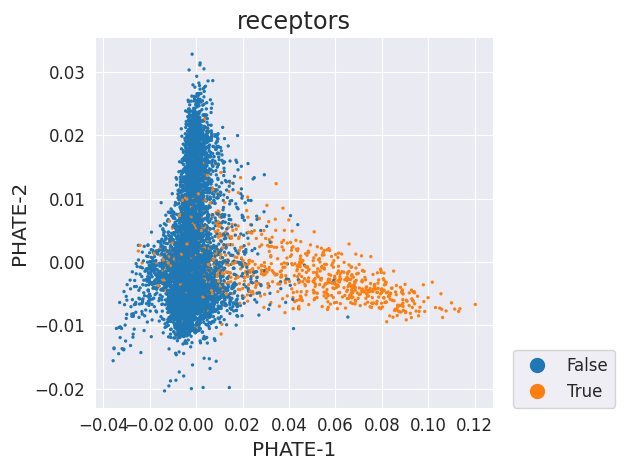

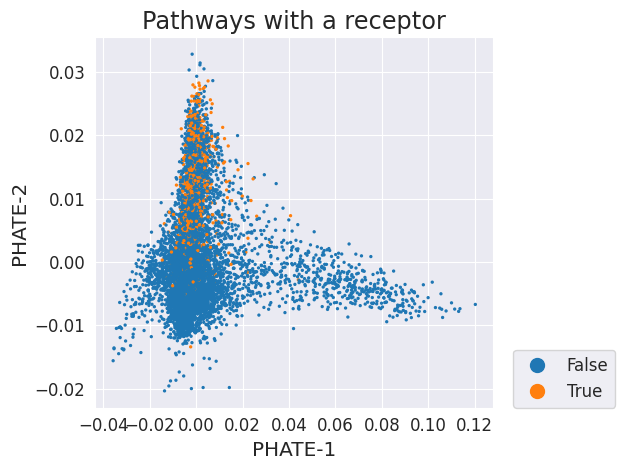

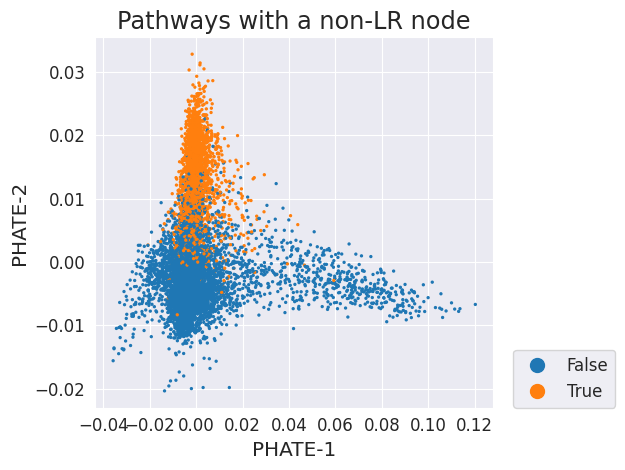

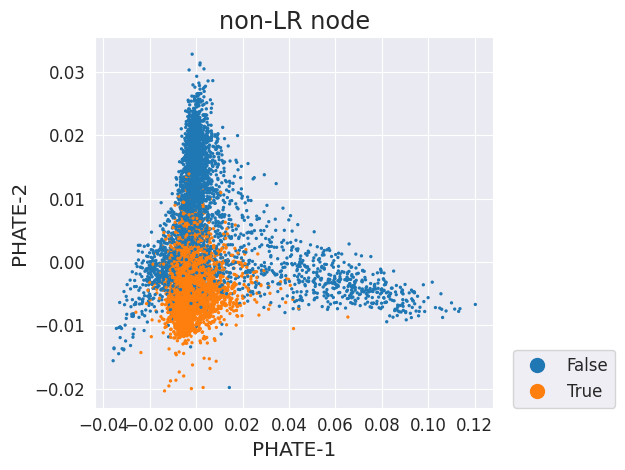

In [39]:
scprep.plot.scatter2d(data_phate, 
    c=data_phate.index.isin(dKGnn.loc[dKGnn[1]=="LR",0]), 
    title="ligands", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(data_phate, 
    c=data_phate.index.isin(dKGnn.loc[dKGnn[1]=="LR",2]), 
    title="receptors", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(data_phate, 
    c=data_phate.index.isin(dKGnn.loc[dKGnn[1]=="R2Path",2]), 
    title="Pathways with a receptor", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(data_phate, 
    c=data_phate.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",0]), 
    title="Pathways with a non-LR node", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

scprep.plot.scatter2d(data_phate, 
    c=data_phate.index.isin(dKGnn.loc[dKGnn[1]=="Path2Gene",2]), 
    title="non-LR node", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

## Clustering

For n_clusters = 2 The average silhouette_score is : 0.025934165
For n_clusters = 3 The average silhouette_score is : 0.01962873
For n_clusters = 4 The average silhouette_score is : 0.018639177
For n_clusters = 5 The average silhouette_score is : 0.018358279
For n_clusters = 6 The average silhouette_score is : 0.018243412
For n_clusters = 8 The average silhouette_score is : 0.018015817


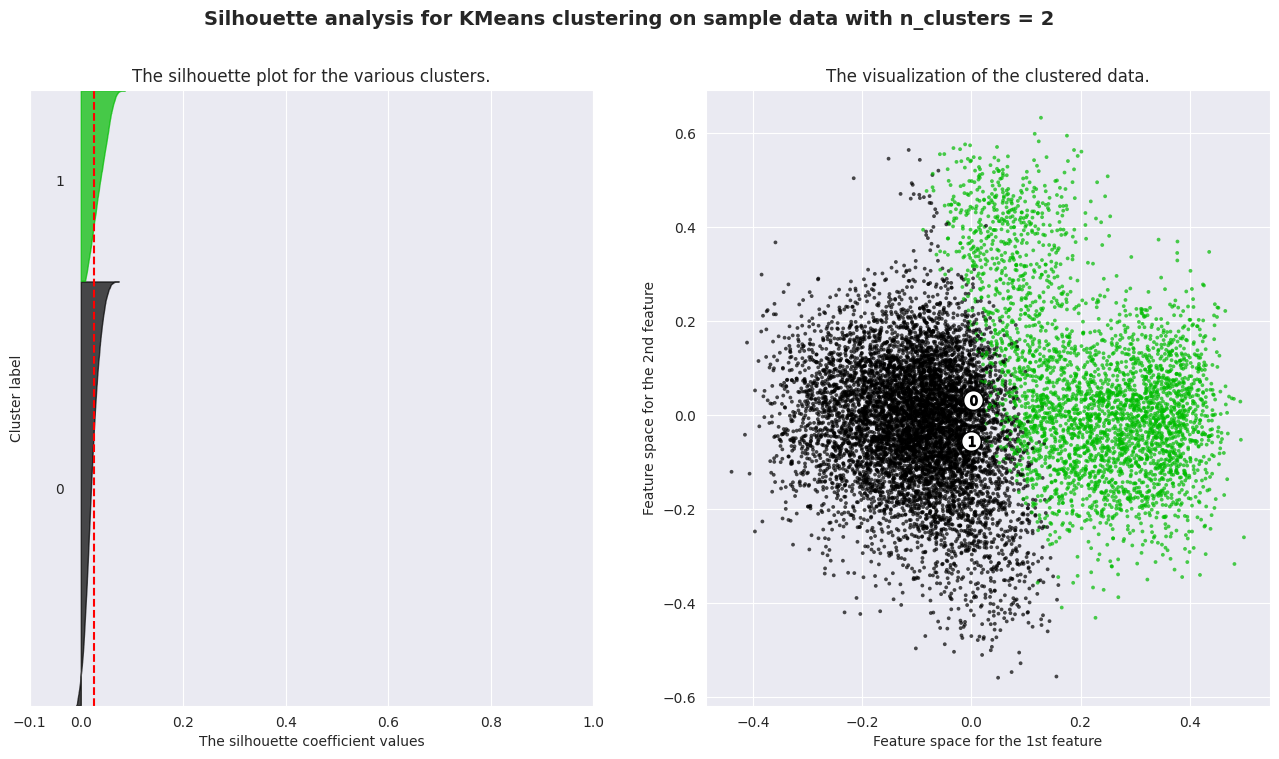

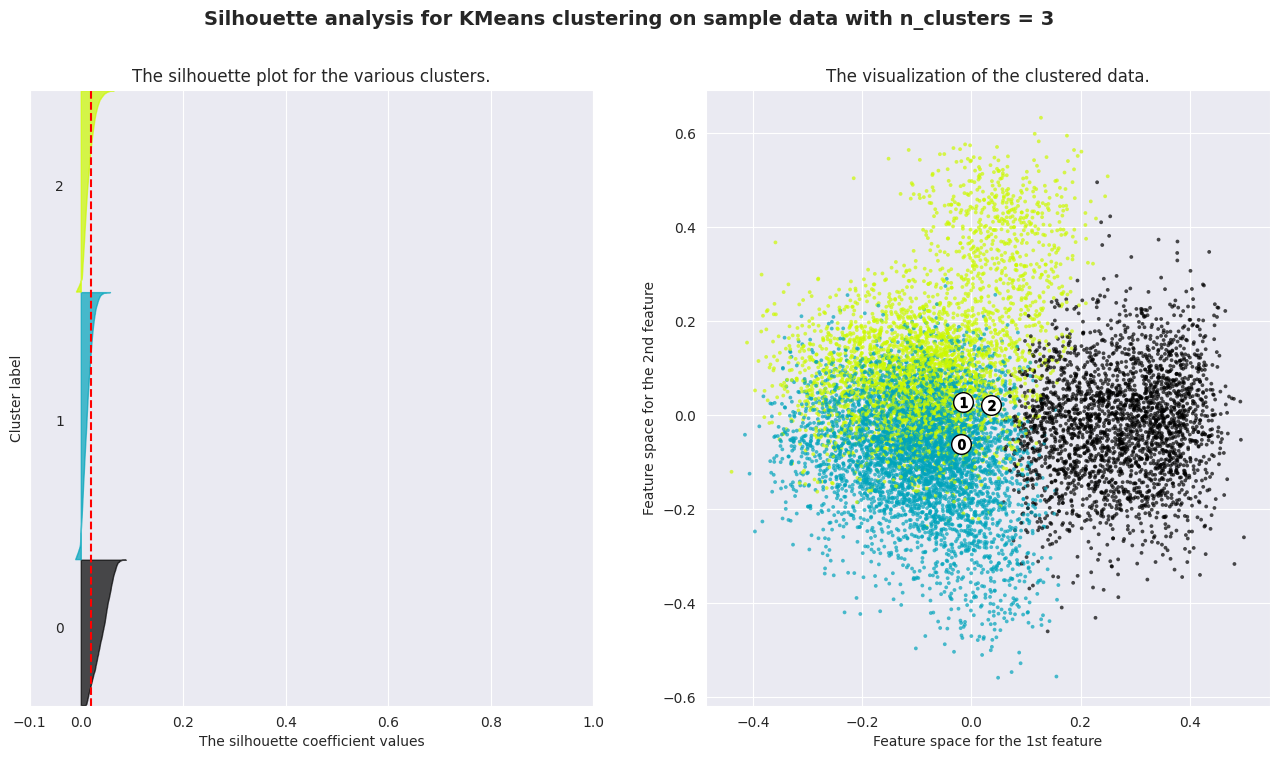

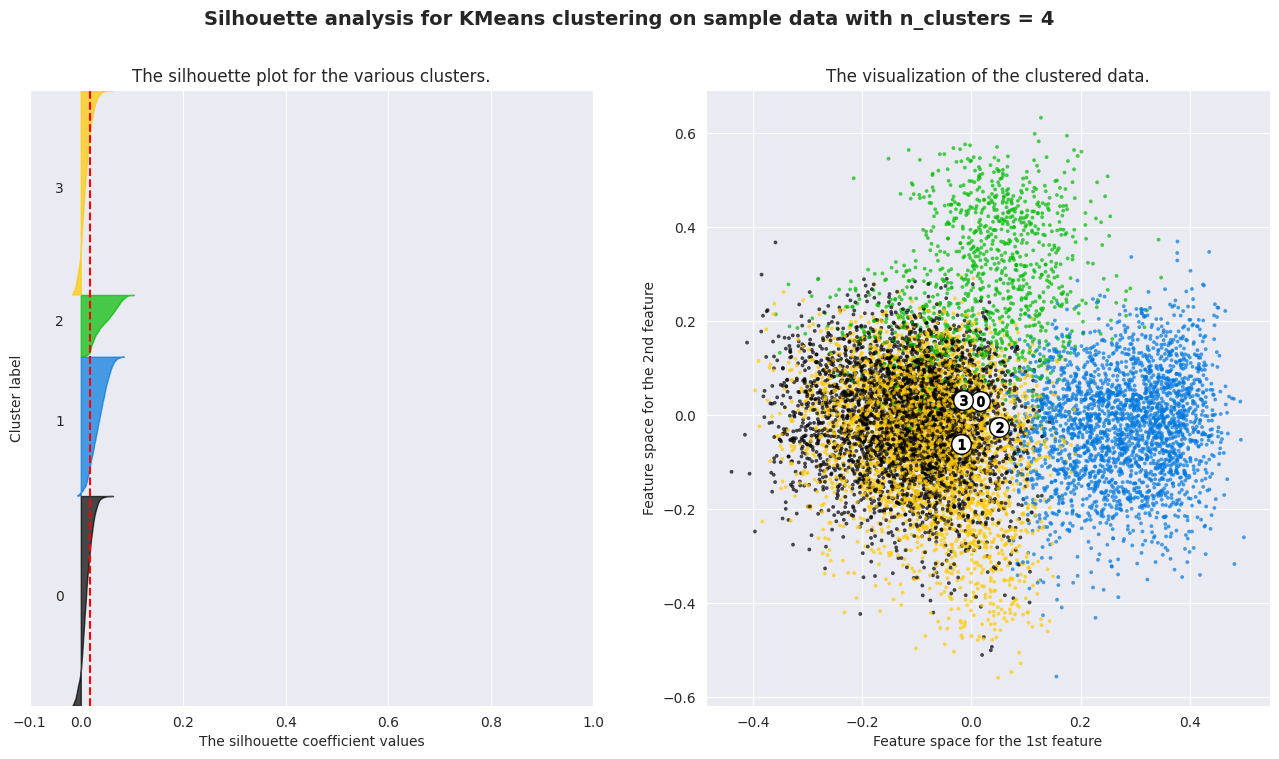

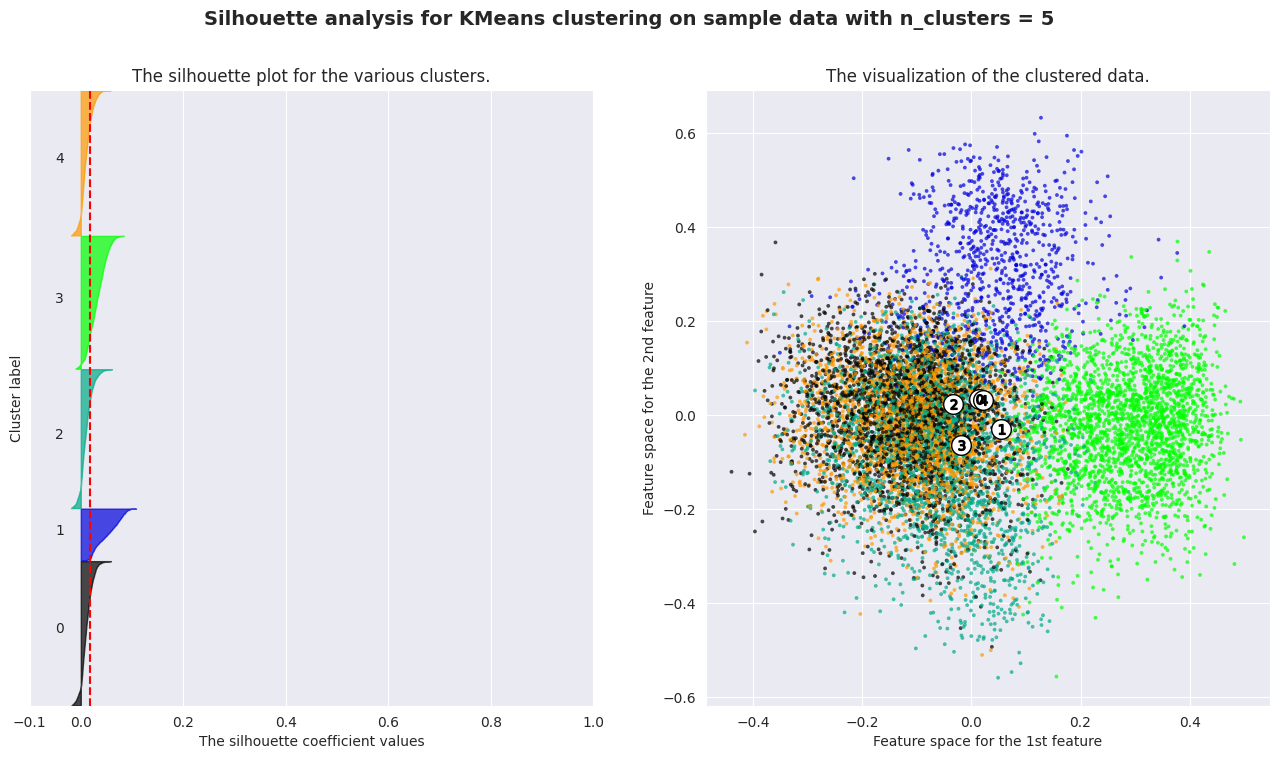

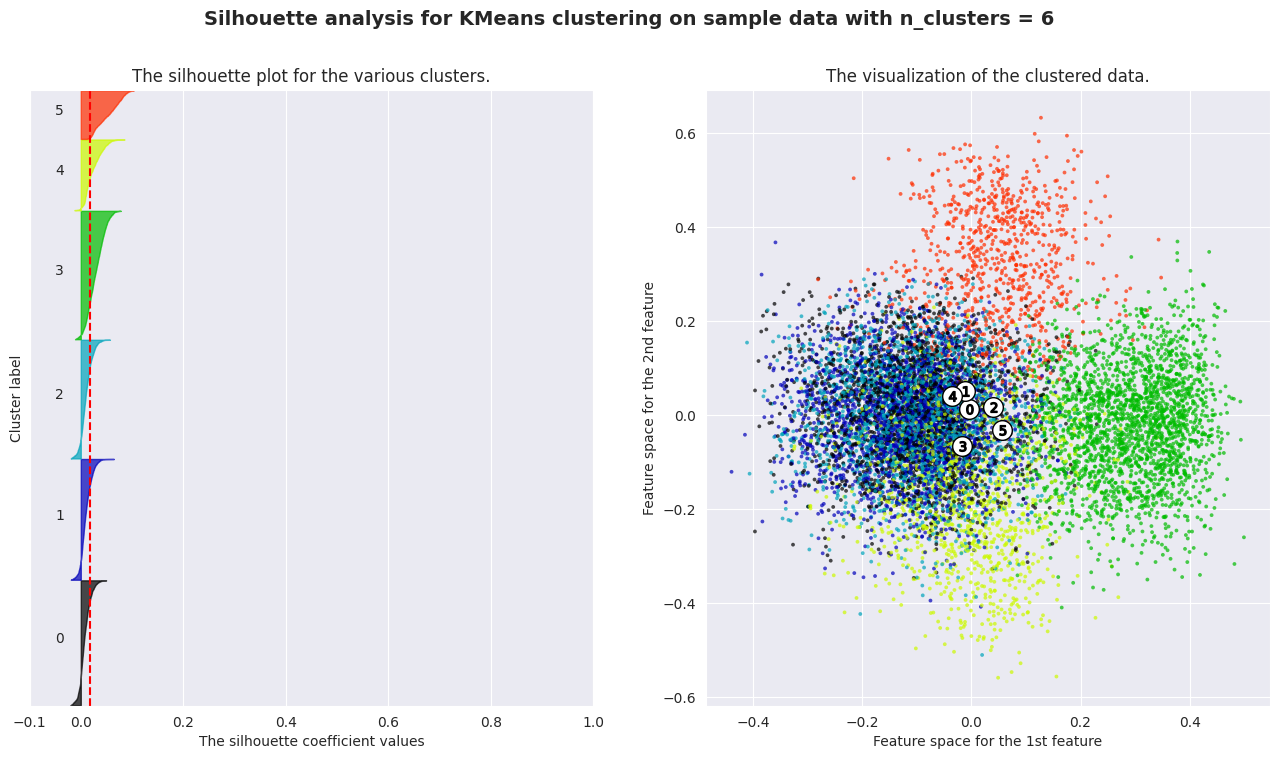

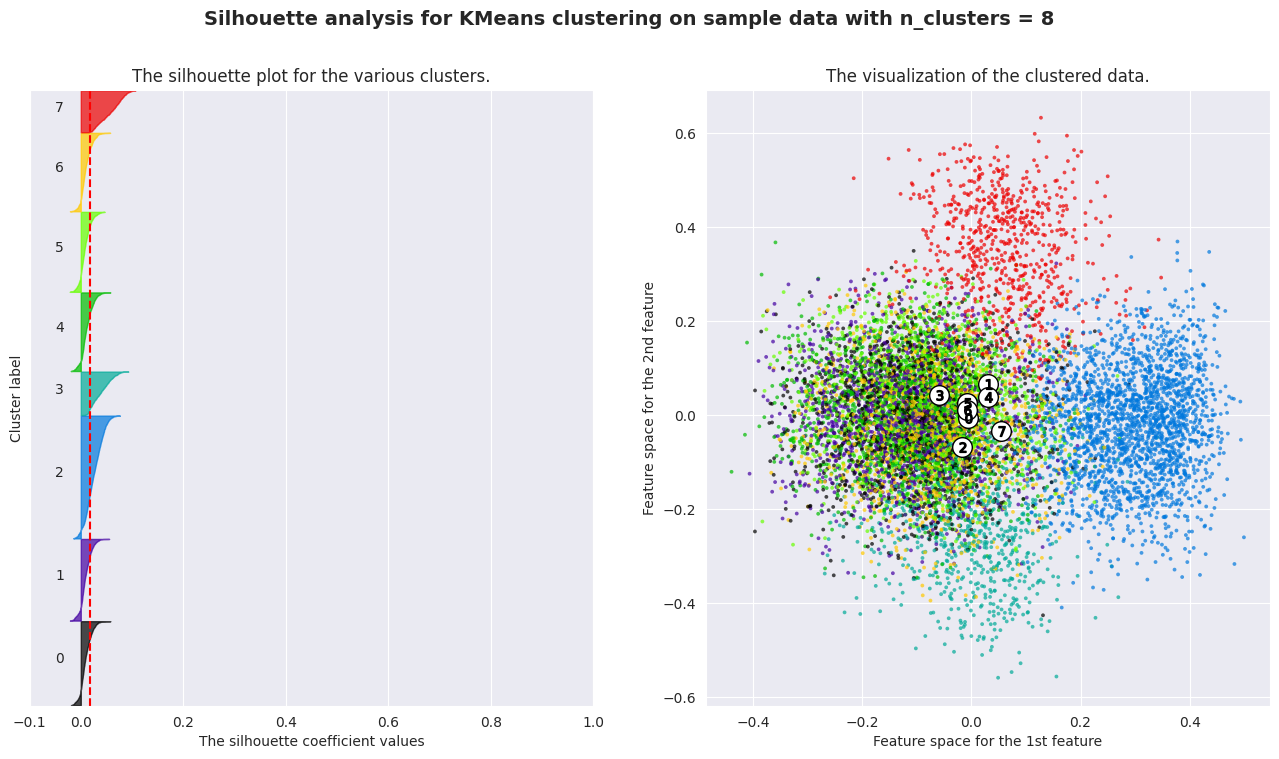

In [40]:
#Snippet from scikit-learn docs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_clust = [2,3,4,5,6,8]

for n_clusters in range_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    # # but in this example all
    # # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dKGEnn_50) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 12 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=12)
    cluster_labels = clusterer.fit_predict(dKGEnn_50)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dKGEnn_50, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dKGEnn_50, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        dKGEnn_pca[0], dKGEnn_pca[1], 
        marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()